<a href="https://colab.research.google.com/github/suneelkumarpentela/Normalizer-free-models/blob/master/NF_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import sklearn
from sklearn.metrics import classification_report, confusion_matrix,precision_recall_fscore_support

In [2]:
os.getcwd()

'/content'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/Mathlogic")

In [5]:
train = pd.read_csv("./Data/train.csv")
print(train.shape)

(90000, 95)


In [6]:
train['target_new'] = np.where(train['target']==0,0,1)
train.drop(['target'],axis=1,inplace=True)

In [7]:
val = pd.read_csv("./Data/valid.csv")
print(val.shape)
val['target_new'] = np.where(val['target']==0,0,1)
val.drop('target',axis=1,inplace=True)

(29000, 95)


In [8]:
test = pd.read_csv("./Data/test.csv")
print(test.shape)
test['target_new'] = np.where(test['target']==0,0,1)
test.drop('target',axis=1,inplace=True)

(29580, 95)


In [9]:
frames = [train,test]
X = pd.concat(frames)

In [10]:
X_train = X.drop('target_new',axis=1)
y_train = np.array([X['target_new']]).reshape(-1,1)
X_train.shape

(119580, 94)

In [11]:
X_test = val.drop('target_new',axis=1)
y_test = np.array([val['target_new']]).reshape(-1,1)
X_test.shape

(29000, 94)

In [12]:
a = y_test.flatten()

In [13]:
from collections import Counter

In [14]:
Counter(y_test.flatten())

Counter({0: 27488, 1: 1512})

In [15]:
Counter(y_train.flatten())

Counter({0: 113300, 1: 6280})

In [16]:
6280/(6280+113300)

0.05251714333500585

In [17]:
y_test.shape

(29000, 1)

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train_np = scaler.transform(X_train)

X_test_np = scaler.transform(X_test)

In [19]:
y_train_np = y_train
y_test_np = y_test

In [20]:
X_train = torch.FloatTensor(X_train_np)

X_test = torch.FloatTensor(X_test_np)

y_train = torch.FloatTensor(y_train_np)
y_test = torch.FloatTensor(y_test_np)

In [21]:
print(y_train.shape)

torch.Size([119580, 1])


In [22]:
X_train_np.shape

(119580, 94)

In [23]:
X_test_np.shape

(29000, 94)

In [24]:
batch_size = 64
num_train_batches = int(X_train_np.shape[0]/batch_size)+1
num_test_batches = int(X_test_np.shape[0]/batch_size)+1
train_data_size = X_train_np.shape[0]
test_data_size = X_test_np.shape[0]
print("Train :",num_train_batches,train_data_size)
print("Test :",num_test_batches,test_data_size)

Train : 1869 119580
Test : 454 29000


In [25]:
train_dataset = TensorDataset(X_train,y_train)
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

In [26]:
test_dataset = TensorDataset(X_test,y_test)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [27]:
train_loader = DataLoader(train_dataset)
test_loader = DataLoader(test_dataset)

In [255]:
# dataiter = iter(train_dataloader)
# images, labels = dataiter.next()
# print(type(images))
# print(images.shape)
# print(labels.shape)

In [256]:
class WSLinear(nn.Linear):

    def __init__(self, in_channels, out_channels,bias=True):
        super().__init__(in_channels, out_channels,bias=bias)

        nn.init.kaiming_normal_(self.weight)
        self.gain = nn.Parameter(torch.ones(
            self.weight.size()[0], requires_grad=True))

    def standardize_weight(self, eps):
        mean = torch.mean(self.weight, dim=(1), keepdims=True)
        var = torch.std(self.weight, dim=(1), keepdims=True, unbiased=False) ** 2
        fan_in = torch.prod(torch.tensor(self.weight.shape))

        scale = torch.rsqrt(torch.max(
            var * fan_in, torch.tensor(eps))) * self.gain.view_as(var)
        shift = mean * scale
        return self.weight * scale - shift

    def forward(self, input, eps=1e-4):
        weight = self.standardize_weight(eps)
        return F.linear(input, weight, self.bias)

In [ ]:
class nf_block(nn.Module):

  def __init__(self,in_units,out_units,alpha,beta):
    super().__init__()

    self.nn = WSLinear(in_units,out_units)
    self.relu = nn.ReLU()

    self.alpha = alpha
    self.beta = beta
    self.skip_gain = nn.Parameter(torch.zeros(()))

  def forward(self,input):

    shortcut = input

    x = input*self.beta
    x = self.nn(x)
    out = shortcut + x*self.alpha*skip_gain

    self.expected_std = (self.expected_std **2 + self.alpha**2)**0.5
    out = relu(out)

    return out

In [257]:
class nf_net(nn.Module):

  def __init__(self,alpha=0.2,beta=1.0):
    super().__init__()

    self.nn1 = WSLinear(94,64)
    self.nn2 = WSLinear(64,64)
    self.nn3 = WSLinear(64,64)
    self.nn4 = WSLinear(64,1)
    self.relu1 = nn.ReLU()
    self.relu2 = nn.ReLU()
    self.relu3 = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.alpha = alpha #rate of change of variance at res bock
    self.expected_std = 1.0
    self.beta = 1.0
    self.skip_gain1 = nn.Parameter(torch.zeros(()))
    self.skip_gain2 = nn.Parameter(torch.zeros(()))

  def forward(self,x):

    x = self.nn1(x)
    x = self.relu1(x)

    shortcut1 = x

    self.beta = 1/(self.expected_std)
    out1 = x*self.beta

    out1 = self.nn2(x)
    out1 = shortcut1 + out1*self.alpha*self.skip_gain1

    self.expected_std = (self.expected_std **2 + self.alpha**2)**0.5
    out1 = self.relu2(out1)

    shortcut2 = out1

    self.beta = 1/(self.expected_std)
    out2 = out1*self.beta

    out2 = self.nn3(out1)
    out2 += shortcut2 + out2*self.alpha*self.skip_gain2
    
    self.expected_std = (self.expected_std **2 + self.alpha**2)**0.5
    out2 = self.relu3(out2)

    out3 = self.nn4(out2)
    out3 = self.sigmoid(out3)

    return out3

In [259]:
model = nf_block()

In [260]:
total_params = sum(p.numel() for p in model.parameters())
total_params

14660

In [261]:
print(model.forward)

<bound method nf_block.forward of nf_block(
  (nn1): WSLinear(in_features=94, out_features=64, bias=True)
  (nn2): WSLinear(in_features=64, out_features=64, bias=True)
  (nn3): WSLinear(in_features=64, out_features=64, bias=True)
  (nn4): WSLinear(in_features=64, out_features=1, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (sigmoid): Sigmoid()
)>


In [262]:
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/Mathlogic'

In [263]:
if(os.getcwd() != r"/content/drive/My Drive/Colab Notebooks/Mathlogic/nfnets_pytorch"):
  os.chdir(r"./nfnets_pytorch")

In [264]:
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/Mathlogic/nfnets_pytorch'

In [265]:
from nfnets import SGD_AGC

In [266]:
# loss_func = nn.BCELoss(reduction="sum")
# optimizer = torch.optim.SGD(model.parameters(),lr=0.001)
loss_func = nn.BCELoss()
optimizer = SGD_AGC(
        named_params=model.named_parameters(), # Pass named parameters
        lr=1e-3,
        momentum=0.9,
        clipping=0.1, # New clipping parameter
        weight_decay=2e-5, 
        nesterov=True)

In [267]:
X_train_np.shape

(119580, 94)

In [268]:
epochs = 100

In [269]:
losses = []
accuracy = []
val_losses = []
val_accuracy = []

for epoch in range(epochs):

  model.train()
  running_loss = 0
  running_val_loss = 0
  running_acc = 0
  running_val_acc = 0

  for i,data in enumerate(train_dataloader):
    train_x,train_y = data
    y_pred = model(train_x)
    loss = loss_func(y_pred,train_y)
    # predicted = model(torch.tensor(X_train_np,dtype=torch.float32))
    acc = (y_pred.reshape(-1).detach().numpy().round() == 
           train_y.reshape(-1).detach().numpy().round()).mean()
    running_loss += loss.item()/(num_train_batches)
    running_acc += acc/(num_train_batches)
    
    #reset grads
    optimizer.zero_grad()
    
    #backward
    loss.backward()

    #weight updates
    optimizer.step()

  print(f'Epoch: {epoch+1} Loss: {running_loss} Accuracy: {running_acc}',end = " ")

  model.eval()  
  for i,data in enumerate(test_dataloader):
    X_val,y_val = data
    y_pred_val = model(X_val)
    val_loss = loss_func(y_pred_val,y_val)
    val_acc = (y_pred_val.reshape(-1).detach().numpy().round() == 
           y_val.reshape(-1).detach().numpy().round()).mean()

    running_val_loss += val_loss.item()/(num_test_batches)
    running_val_acc += val_acc/(num_test_batches)
    
  print(f'Val Loss: {running_val_loss} Val Accuracy: {running_val_acc}')


  losses.append(running_loss)
  accuracy.append(running_acc)
  val_losses.append(running_val_loss)
  val_accuracy.append(running_val_acc)  

Epoch: 1 Loss: 0.35803694061938984 Accuracy: 0.8853987521975081 Val Loss: 0.2020885664969682 Val Accuracy: 0.9479625550660862
Epoch: 2 Loss: 0.20219739222148642 Accuracy: 0.9474903023006992 Val Loss: 0.19947294902368257 Val Accuracy: 0.9479625550660861
Epoch: 3 Loss: 0.19988842951726865 Accuracy: 0.9474903023006956 Val Loss: 0.1988279331015988 Val Accuracy: 0.9474807268722535
Epoch: 4 Loss: 0.19807259129722118 Accuracy: 0.9474903023006979 Val Loss: 0.195791673973728 Val Accuracy: 0.9479625550660863
Epoch: 5 Loss: 0.19661290712411436 Accuracy: 0.9474688049377085 Val Loss: 0.19461482133929678 Val Accuracy: 0.9479625550660861
Epoch: 6 Loss: 0.19535088115568577 Accuracy: 0.9474604448520998 Val Loss: 0.19330333339846356 Val Accuracy: 0.9479625550660862
Epoch: 7 Loss: 0.1941832881291296 Accuracy: 0.9474711935335948 Val Loss: 0.19311933255536964 Val Accuracy: 0.9477216409691699
Epoch: 8 Loss: 0.19324530594333916 Accuracy: 0.9474604448520997 Val Loss: 0.1918806355807617 Val Accuracy: 0.9477216

Text(0, 0.5, 'loss')

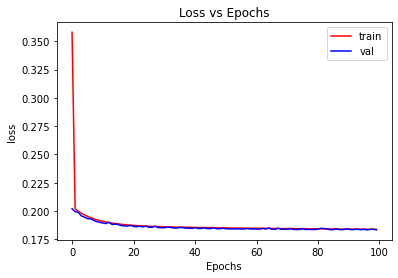

In [270]:
plt.plot(losses,'r',label='train')
plt.plot(val_losses,'b',label='val')
plt.legend()
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

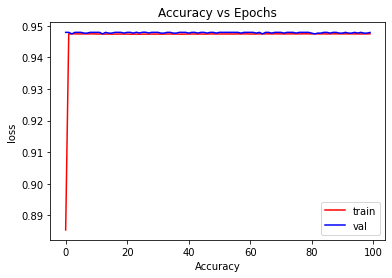

In [271]:
plt.plot(accuracy,'r',label='train')
plt.plot(val_accuracy,'b',label='val')
plt.legend()
plt.title('Accuracy vs Epochs')
plt.xlabel('Accuracy')
plt.ylabel('loss')

In [272]:
model.eval()
preds_train = []
with torch.no_grad():
   for i,data in enumerate(train_loader):
     trainx,trainy = data
     y_hat = model.forward(trainx)
     preds_train.append(y_hat)

In [273]:
preds_train = np.array(preds_train)
preds_train

array([0.0670393 , 0.00645583, 0.03716525, ..., 0.03160442, 0.02750487,
       0.05153205], dtype=float32)

In [274]:
def best_f1(preds,y_test_np):
  f1_max = 0
  cutoff = -1
  for i in np.arange(0.01,1,0.01):
    preds1 = (preds>=i)*1 
    #print(sum(preds1))
    f1_score = sklearn.metrics.precision_recall_fscore_support(preds1,y_test_np)[2][1]
    print(f1_score)
    if (not f1_score):
      break
    if (f1_score > f1_max):
      f1_max = f1_score
      cutoff = i
  return cutoff,f1_max

In [275]:
train_cutoff,train_f1 = best_f1(preds_train,y_train_np)

0.11258963420168829
0.12985270084526557
0.14562508030322496
0.1596299309887593
0.17128401953942776
0.1820218874417302
0.19234575288242467
0.20154364604848354
0.21020578885728627
0.21730617006207556
0.2186255231180356
0.2154666666666667
0.210038188761593
0.20527408318597679
0.1957207399198704
0.18256181446365496
0.16978851963746225
0.15563950350782516
0.14251290877796902
0.1306859205776173
0.11958710976837864
0.10465724751439039
0.09187659975751045
0.08064292642372176
0.07026027592092163
0.062201649066975256
0.04957945993802568
0.04343918514080287
0.03785584494245911
0.032031726662599146
0.026433072076225604
0.02228412256267409
0.016827672172016202
0.013145539906103287
0.010990736379337415
0.00787897888433659
0.006945540647198106
0.005377194369761189
0.003484872485347695
0.0031710797526557795
0.002223280927425758
0.0022236340533672173
0.0019068806610519626
0.001271657924018439
0.001271860095389507
0.0012722646310432569
0.0009543502465404803
0.0009545020680878142
0.0009545020680878142
0.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [276]:
train_cutoff,train_f1

(0.11, 0.2186255231180356)

In [277]:
preds_train_ideal = (preds_train>=train_cutoff)*1

In [278]:
print(classification_report(preds_train_ideal,y_train_np))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93    106027
           1       0.35      0.16      0.22     13553

    accuracy                           0.87    119580
   macro avg       0.62      0.56      0.57    119580
weighted avg       0.84      0.87      0.85    119580



In [279]:
model.eval()
preds = []
with torch.no_grad():
   for i,data in enumerate(test_loader):
     test_x,test_y = data
     y_hat = model.forward(test_x)
     preds.append(y_hat)

In [280]:
np.array(preds)

array([0.03414324, 0.01423776, 0.1903945 , ..., 0.10365236, 0.08442285,
       0.10784815], dtype=float32)

In [281]:
preds = np.array(preds)
# preds[preds>=0.5] = 1
# preds[preds<=0.5] = 0


In [282]:
np.unique(preds)

array([9.3499133e-05, 1.2494100e-04, 1.6504656e-04, ..., 4.2650259e-01,
       4.5736414e-01, 5.0609219e-01], dtype=float32)

In [283]:
preds_dummy = (preds>=0.5)*1

In [284]:
sklearn.metrics.precision_recall_fscore_support(preds_dummy,y_test_np)

(array([0.99996362, 0.        ]),
 array([0.94786027, 0.        ]),
 array([0.97321508, 0.        ]),
 array([28999,     1]))

In [285]:
sklearn.metrics.precision_recall_fscore_support(preds_dummy,y_test_np)[2][1]

0.0

In [286]:
np.arange(0.01,1,0.01)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

In [287]:
cutoff,f1_max = best_f1(preds,y_test_np)

0.11187077385424492
0.12811547426932043
0.1444285031085605
0.15822233287688287
0.1695573947463116
0.18041024796111707
0.19014151391395195
0.2020497803806735
0.20906492445896285
0.21341463414634143
0.21236393509960977
0.20806179097272506
0.20498614958448752
0.1930862659607599
0.19393093826299268
0.18376722817764163
0.166598611678236
0.15296703296703298
0.13696060037523453
0.12935323383084577
0.1204323211528564
0.11367292225201071
0.0969359331476323
0.08710601719197708
0.07896287566293458
0.05914302957151479
0.05382262996941896
0.04477611940298507
0.04153555695405915
0.03677869372225745
0.03437301082113304
0.02697495183044316
0.02324080051646223
0.018170019467878
0.014341590612777051
0.01045751633986928
0.006561679790026246
0.006565988181221273
0.0026333113890717576
0.0026333113890717576
0.0013175230566534913
0.0


In [288]:
print(cutoff,f1_max)

0.09999999999999999 0.21341463414634143


In [289]:
preds_ideal = (preds>=cutoff)*1

In [290]:
print(classification_report(preds_ideal,y_test_np))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91     24608
           1       0.42      0.14      0.21      4392

    accuracy                           0.84     29000
   macro avg       0.64      0.55      0.56     29000
weighted avg       0.80      0.84      0.81     29000

